In [187]:
import pandas as pd
import re
import emoji
import numpy as np
import collections
import plotly.express as px
import matplotlib.pyplot as plt

def startsWithDateAndTime(s):
    # regex pattern for date
    pattern = r'^\d{1,2}/\d{1,2}/\d{2}, \d{1,2}:\d{2}'
    result = re.match(pattern, s)
    if result:
        return True
    return False

# Finds username of any given format.
def FindAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '[\w]+ ?[^\s\u1f300-\u1f5ff]:',    # Name and Emoji              
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

def getDataPoint(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe

# Enter file path as input so any chat can be analyzed --------------------------------------------------------------------------
print('Enter file path/name:')
File = input()
conversationPath = File # chat file
#--------------------------------------------------------------------------------------------------------------------------------

with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file because contains information related to something about end-to-end encryption
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
            messageBuffer.append(line)

Enter file path/name:
Group_chat1.txt


In [188]:
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
df["Date"] = pd.to_datetime(df["Date"])

# Deleting cases of Author being None
df = df.dropna()

# if for some reason you need to keep the original names, remove the following code:

#--------------------------------------------------------------------------------------------------------------
# Changing names
# Getting random names from a Game of thrones list
got_dt = pd.read_csv("https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-all-nodes.csv")

# Defining names and aliases
names = list(df.Author.unique())
aliases = list(got_dt.Label.sample(len(names)))

# Replacing for Author
df.Author.replace(names, aliases, inplace=True)

# Replacing within messages
for (name, alias) in zip(names, aliases):
    df.Message = df.Message.str.replace(name, alias)
#-----------------------------------------------------------------------------------------------------------------

df.head()

,Date,Time,Author,Message
0,2019-12-25,00:17,Gyles Rosby,Feliz Navidad 🎁 !!
1,2019-12-25,00:17,Gyles Rosby,🎄
2,2019-12-25,00:17,Gyles Rosby,Les mando un abrazo bonitas 🤗🤗🤗🤗
3,2019-12-25,00:51,Gorold Goodbrother,Feliz navidaddd las amo 😘
4,2019-12-25,01:12,Gyles Rosby,<Media omitted>


In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14894 entries, 0 to 14894
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     14894 non-null  datetime64[ns]
 1   Time     14894 non-null  object        
 2   Author   14894 non-null  object        
 3   Message  14894 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 581.8+ KB


In [160]:
#This function will not run correctly if emoji is not installed and imported

def split_count(text):

    emoji_list = []
    data = re.findall(r'[^\s\u1f300-\u1f5ff]', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

total_messages = df.shape[0]
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
df["emoji"] = df["Message"].apply(split_count)
emojis = sum(df['emoji'].str.len())
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)

print("Group Wise Stats")
print("Messages:", total_messages)
print("Media:", media_messages)
print("Emojis:", emojis)
print("Links:", links)

Group Wise Stats
Messages: 14894
Media: 1216
Emojis: 5970
Links: 85


In [162]:
media_messages_df = df[df['Message'] == '<Media omitted>']
messages_df = df.drop(media_messages_df.index)
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))

In [163]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]

l = messages_df.Author.unique()

for i in range(len(l)): 
  # Filtering out messages of particular user
    req_df = messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
    print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
    print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
    words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
    print('Words per message', words_per_message)
  #media conists of media messages
    media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
    print('Media Messages Sent', media)
  # emojis conists of total emojis
    emojis = sum(req_df['emoji'].str.len())
    print('Emojis Sent', emojis)
  #links consist of total links
    links = sum(req_df["urlcount"])   
    print('Links Sent', links)
    print()

Stats of Denyo Terys -
Messages Sent 6881
Words per message 6.240081383519837
Media Messages Sent 362
Emojis Sent 3581
Links Sent 35

Stats of Bedwyck -
Messages Sent 3768
Words per message 7.3274946921443735
Media Messages Sent 368
Emojis Sent 1151
Links Sent 25

Stats of Olenna Redwyne -
Messages Sent 3029
Words per message 5.6464179597226805
Media Messages Sent 486
Emojis Sent 1238
Links Sent 25



In [164]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

139


In [165]:
# collections was installed and imported, Counter was changed to collections.Counter

total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(collections.Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,🤣,1859
1,👀,279
2,♀,234
3,🥰,228
4,😅,210
...,...,...
134,🧞,1
135,🤴,1
136,🍕,1
137,💕,1


In [166]:
fig = px.pie(emoji_df, values='count', names='emoji',
             title='Emoji Distribution')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [167]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()
for i in range(len(l)):
    dummy_df = messages_df[messages_df['Author'] == l[i]]
    total_emojis_list = list([a for b in dummy_df.emoji for a in b])
    emoji_dict = dict(collections.Counter(total_emojis_list))
    emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
    print('Emoji Distribution for', l[i])
    author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
    fig = px.pie(author_emoji_df, values='count', names='emoji')
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.show()

Emoji Distribution for Denyo Terys


Emoji Distribution for Bedwyck


Emoji Distribution for Olenna Redwyne


In [168]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))

There are 454305 words in all the messages.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brend\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


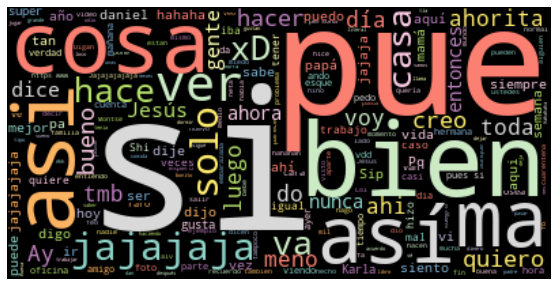

In [185]:
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
from wordcloud import WordCloud 

# the language will change depending on the context, adjust this as needed.
stopwords = set(stopwords.words('spanish', 'english')) 

# this list can also be updated or modified as needed.
stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","la","eh","ne","le"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="black", colormap='Set3').generate(text)

# Display the generated image:
# the matplotlib way: 
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# saving the wordcloud as image is optional
#print('Enter name for image')
#imname = input()
#plt.savefig(imname, format="jpg", facecolor='black', bbox_inches='tight')

plt.show()

In [172]:
#changed message count to Word_Count because messagecount did not exist in the dataframe date_df

date_df = messages_df.groupby("Date").sum()

date_df.reset_index(inplace=True)

fig = px.line(date_df, x="Date", y="Word_Count", title='Number of Messages as time moves on.')

fig.update_xaxes(nticks=20)

fig.show()

Text(0, 0.5, 'Date')

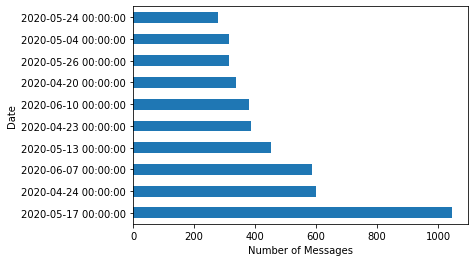

In [173]:
messages_df['Date'].value_counts().head(10).plot.barh()
plt.xlabel('Number of Messages')
plt.ylabel('Date')

In [174]:
def dayofweek(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(dayofweek)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)


fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0,3000] # adjust this for better resolution depending on how much the group is used
    )),
  showlegend=False
)

fig.show()

Text(0, 0.5, 'Time')

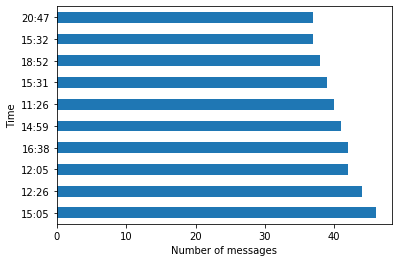

In [175]:
messages_df['Time'].value_counts().head(10).plot.barh() 

plt.xlabel('Number of messages')

plt.ylabel('Time')